<a href="https://colab.research.google.com/github/clemencia/ML4PPGF_UERJ/blob/master/Exemplos_GAN/GAN_keras_upscaling_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Adversariais para Melhorias (*Upscaling*)


In [1]:
#@title Download DIV2K Dataset
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

--2019-11-08 15:00:10--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2019-11-08 15:00:12--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  9.64MB/s    in 6m 2s   

2019-11-08 15:06:15 (9.30 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]



In [2]:
#@title Import Dependencies
import  os,shutil
import cv2
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from keras.models import Input, Model
from keras.layers import BatchNormalization, LeakyReLU, Conv2D, Dense, \
                         Flatten, Add, PReLU, Conv2DTranspose, Lambda, UpSampling2D                    
from keras.optimizers import Adam
from keras.applications import VGG19
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

Using TensorFlow backend.


In [3]:
#@title Creating folder for the data and unziping the file
!mkdir train_data
shutil.move('./DIV2K_train_HR.zip','./train_data')
os.chdir('./train_data')
!unzip DIV2K_train_HR.zip
os.chdir('./DIV2K_train_HR')

Archive:  DIV2K_train_HR.zip
   creating: DIV2K_train_HR/
  inflating: DIV2K_train_HR/0103.png  
  inflating: DIV2K_train_HR/0413.png  
  inflating: DIV2K_train_HR/0031.png  
  inflating: DIV2K_train_HR/0660.png  
  inflating: DIV2K_train_HR/0126.png  
  inflating: DIV2K_train_HR/0793.png  
  inflating: DIV2K_train_HR/0764.png  
  inflating: DIV2K_train_HR/0550.png  
  inflating: DIV2K_train_HR/0437.png  
  inflating: DIV2K_train_HR/0374.png  
  inflating: DIV2K_train_HR/0755.png  
  inflating: DIV2K_train_HR/0614.png  
  inflating: DIV2K_train_HR/0646.png  
  inflating: DIV2K_train_HR/0371.png  
  inflating: DIV2K_train_HR/0312.png  
  inflating: DIV2K_train_HR/0108.png  
  inflating: DIV2K_train_HR/0556.png  
  inflating: DIV2K_train_HR/0794.png  
  inflating: DIV2K_train_HR/0722.png  
  inflating: DIV2K_train_HR/0780.png  
  inflating: DIV2K_train_HR/0555.png  
  inflating: DIV2K_train_HR/0439.png  
  inflating: DIV2K_train_HR/0396.png  
  inflating: DIV2K_train_HR/0666.png  
  infl

In [0]:
def crop_center(img,cropx,cropy):
    y,x,_ = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx,:]

In [0]:
#@title Resizing the image
img_list, img_low_list = [], []
for i in os.listdir():
  if '.png' in i:
    img = cv2.imread(i)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_crop = crop_center(img,256,256)
    img_list.append(img_crop)
    img_low_list.append(cv2.resize(img_crop,(64,64)))

high_reso_imgs = np.array(img_list)
low_reso_imgs = np.array(img_low_list)    
  

In [0]:
os.chdir('/content')

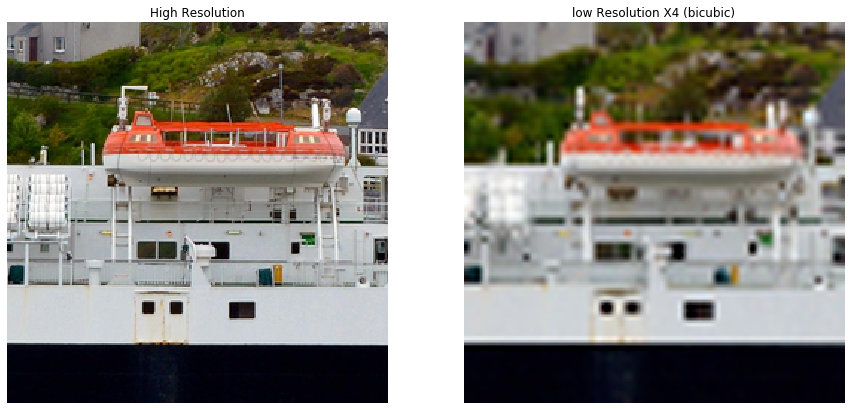

In [7]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(high_reso_imgs[2])
plt.grid('off')
plt.axis('off')
plt.title('High Resolution')
plt.subplot(1,2,2)
plt.imshow(cv2.resize(low_reso_imgs[2],(256,256),
                      interpolation = cv2.INTER_CUBIC))
plt.grid('off')
plt.axis('off')
_=plt.title('low Resolution X4 (bicubic)')

In [0]:
#@title Creating the model
class SRGAN():
  # Implementation of SRGAN from paper:
  # https://arxiv.org/abs/1609.04802
    def __init__(self,lr_height = 64,lr_width = 64,channels = 3,
              upscale_factor = 4, generator_lr = 1e-4, discriminator_lr = 1e-4, gan_lr = 1e-4):
        self.height_low_reso = lr_height
        self.width_low_reso = lr_width

        if upscale_factor % 2 != 0:
            raise ValueError('Upscale factor is invalid, must be product of 2')

        self.upscale_factor = upscale_factor
        self.height_high_reso = self.height_low_reso * self.upscale_factor
        self.width_high_reso = self.width_low_reso * self.upscale_factor

        self.channels = channels
        self.shape_low_reso = (self.height_low_reso,self.width_low_reso,self.channels)
        self.shape_high_reso = (self.height_high_reso,self.width_high_reso,self.channels)

        self.samples = high_reso_imgs.shape[0]

        opti_generator = Adam(generator_lr,0.9)
        opti_discriminator = Adam(discriminator_lr,0.9)
        opti_gan = Adam(gan_lr,0.9) 

        self.vgg = self.bulid_vgg()

        self.discriminator = self.build_discriminator(opti_discriminator)
        self.discriminator.trainable = False
        self.generator = self.build_generator(opti_generator)
        self.srgan = self.build_srgan(opti_gan)

    def save_GAN_Model(self,epoch):
        self.srgan.save_weights('srgan_weights_epoch_%d.h5' % epoch)


    def plotLosses(self,dlosses,glosses,epo):
        fig, ax1 = plt.subplots(figsize = (10,12))
        color = 'tab:blue'
        ax1.plot(dlosses,color = color, label = 'Dis loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Dis loss', color = color)
        ax1.tick_params('y',color = color)
        color = 'tab:green'
        ax2 = ax1.twinx()
        ax2.plot(glosses, color = color, label = 'Gen loss')
        ax2.set_ylabel('Gen loss', color = color)
        ax2.tick_params('y', color = color)
        plt.title('Discriminator & Generator Losses')
        plt.savefig('Losses_%d.png' % epo)
        plt.show()

    def gen_pipeline(self, batch_size = 16):
        while(1):
            indx_high = np.random.randint(0,high_reso_imgs.shape[0]-1,batch_size)
            
            indx_low = np.random.randint(0,low_reso_imgs.shape[0]-1,batch_size)
            
            real = np.ones((batch_size,) + self.discriminator.output_shape[1:])
            
            fake = np.zeros((batch_size,) + self.discriminator.output_shape[1:])
            
            norm_hr = high_reso_imgs[indx_high]/127.5-1
            norm_lr = low_reso_imgs[indx_low]/127.5 -1
            yield(norm_hr,real,norm_lr,fake)
            
    def vgg_pipeline(self, batch_size = 16):
      while(1):
        indx = np.random.randint(0,high_reso_imgs.shape[0]-1,batch_size)
        real = np.ones((batch_size,) + self.discriminator.output_shape[1:])
        norm_hr = high_reso_imgs[indx]/127.5-1
        norm_lr = low_reso_imgs[indx]/127.5 -1
        yield(norm_hr,norm_lr,real)
            
      
    def bulid_vgg(self):
        vgg = VGG19(weights = "imagenet")
#         vgg.summary()
        vgg.outputs = [vgg.layers[9].output]
        img = Input(shape = self.shape_high_reso)
        img_features = vgg(img)
        vgg_model = Model(img, img_features)
#         for layer in vgg_model.layers:
#             layer.trainable = False
        vgg_model.compile(loss = 'mse', optimizer = Adam(0.0002,0.5),
                         metrics =['acc'])
        return vgg_model


    def residual_block(self,input_layer):
        x = Conv2D(filters = 64, kernel_size = 3, padding = 'same')(input_layer)
        x = BatchNormalization(momentum=0.8)(x)
        x = PReLU()(x)
        x = Conv2D(filters = 64, kernel_size = 3, padding = 'same')(x)
        x = BatchNormalization(momentum=0.8)(x)
        return Add()([input_layer,x])

    def disc_block(self,layer, n_filters, batch_norm = True):
        x = Conv2D(filters = n_filters, kernel_size = 3, padding = 'same')(layer)
        if batch_norm:
            x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters = n_filters, kernel_size = 3,
                   strides=2, padding = 'same')(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x

    def Upsample_Block(self,x_in):
        x = Conv2D(filters = 256, kernel_size=3, padding='same')(x_in)
        x = self.SubpixelConv2D(2)(x)
        return PReLU()(x)
      
    def SubpixelConv2D(self,scale):
        return Lambda(lambda x: tf.depth_to_space(x, scale))
  
    def build_generator(self,opti_generator,n_blocks = 16):
        input_layer = Input(self.shape_low_reso)
        
        first_layer = Conv2D(filters = 64, kernel_size = 9,
                             padding = 'same')(input_layer)
        
        first_layer = PReLU()(first_layer)
        
        residual_blocks = self.residual_block(first_layer)
        
        for _ in range(n_blocks-1):
            residual_blocks = self.residual_block(residual_blocks)

        output_residual = Conv2D(filters = 64, kernel_size = 3,
                             padding = 'same')(residual_blocks)
        
        output_residual = BatchNormalization(momentum=0.8)(output_residual)
        
        output_residual = Add()([output_residual,first_layer])
               
        upsample_layer = self.Upsample_Block(output_residual)
        
        for _ in range(self.upscale_factor//2-1):
            upsample_layer =  self.Upsample_Block(upsample_layer)
            
        gen_output = Conv2D(filters = 3, kernel_size = 9,
                            padding = 'same', activation = 'tanh')(upsample_layer)

        gen_model = Model(inputs = input_layer, outputs = gen_output)
        gen_model.compile(loss = 'binary_crossentropy', optimizer = opti_generator)

        return gen_model

    def build_discriminator(self,opti_discriminator,n_blocks = 3, n_filters = 64):
        input_layer = Input(self.shape_high_reso)
        discriminator_blocks = self.disc_block(input_layer,n_filters,False)
        for i in range(n_blocks):
            discriminator_blocks = self.disc_block(discriminator_blocks, 
                                             n_filters = (i+1)*2*n_filters)
        
        #f_layer = GlobalAveragePooling2D()(discriminator_blocks)
        f_layer = Dense(units = 1024)(discriminator_blocks)
        f_layer = LeakyReLU(alpha=0.2)(f_layer)
        dis_output = Dense(units = 1, activation = 'sigmoid')(f_layer)
        disc_model = Model(inputs = input_layer, outputs = dis_output)
        disc_model.compile(loss = 'mse', optimizer = opti_discriminator,
                          metrics = ['accuracy'])

        return disc_model

    def build_srgan(self,optimizer):
        dis_input = Input(self.shape_high_reso)
        gen_input = Input(self.shape_low_reso)

        generated_high_reso = self.generator(gen_input)
        generated_features = self.vgg(generated_high_reso)
        generator_valid = self.discriminator(generated_high_reso)


        gan_model = Model(inputs = [gen_input, dis_input], 
                          outputs = [generator_valid, generated_features])
        
        for l in gan_model.layers[-1].layers[-1].layers:
          l.trainable=False
        
        gan_model.compile(loss = ['binary_crossentropy','mse'], loss_weights = [1e-2,1], optimizer = 'adam')
        gan_model.summary()
        
        return gan_model



    def train(self, epochs, save_interval = 100, batch_size = 16):
        pipeline = self.gen_pipeline(batch_size)
        vgg_pipeline = self.vgg_pipeline(batch_size)

        batch_count = self.samples // batch_size
        dlosses = []
        glosses = []
        for epo in range(1,epochs+1):
            print ('-'*15,'Epoch %d' % epo, '-'*15)
            for _ in tqdm(range(batch_count)):

                ##########################

                # Train the Discriminator

                ##########################

                # Generate Batch
                hr_imgs, real, lr_imgs, fake = next(pipeline)

                # Generate high resolution photos from low resolution photos
                generated_hr_imags = self.generator.predict(lr_imgs)

                # Train the discriminator 
                real_dis_loss = self.discriminator.train_on_batch(hr_imgs,real)
                fake_dis_loss = self.discriminator.train_on_batch(generated_hr_imags,fake)
                dis_loss = (0.5*np.add(real_dis_loss,fake_dis_loss))

                ##########################

                # Train the Generator

                ##########################

                #Generate Batch
                hr_imgs, lr_imgs, real = next(vgg_pipeline)

                # Extract ground truth using VGG model
                img_features = self.vgg.predict(hr_imgs)

                gan_loss = self.srgan.train_on_batch([lr_imgs,hr_imgs], [real, img_features])


            if epo % save_interval == 0:
              self.save_GAN_Model(epo)
              self.plotLosses(dlosses,glosses,epo)
            dlosses.append(gan_loss[1])
            glosses.append(gan_loss[0])
            print('\n',dlosses[-1],glosses[-1])


In [0]:
def plot_predict(low_reso_imgs,high_reso_imgs,srgan_model,n_imgs = 4):
    plt.figure(figsize = (12,12))
    plt.tight_layout()
    for i in range(0,n_imgs*3,3):
        idx = np.random.randint(0,low_reso_imgs.shape[0]-1)
        plt.subplot(n_imgs,3,i+1)
        plt.imshow(high_reso_imgs[idx])
        plt.grid('off')
        plt.axis('off')
        plt.title('Source')
        plt.subplot(n_imgs,3,i+2)
        plt.imshow(cv2.resize(low_reso_imgs[idx],(256,256),
                          interpolation = cv2.INTER_CUBIC))
        plt.grid('off')
        plt.axis('off')
        plt.title('X4 (bicubic)')
        
        img = srgan_model.generator.predict(np.expand_dims(low_reso_imgs[idx], axis = 0) / 127.5 - 1)
        img_unnorm = (img+1) * 127.5
        plt.subplot(n_imgs,3,i+3)
        plt.imshow(np.squeeze(img_unnorm, axis = 0).astype(np.uint8))
        plt.grid('off')
        plt.axis('off')
        plt.title('SRGAN')
        
    plt.savefig('predicted.png')
        

In [10]:
model_srgan = SRGAN()





574717952/574710816 [==============================] - 42s 0us/step










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 256, 256, 3)  11252995    input_6[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 16, 16, 1)    3759681     model_3[1][0]                    
__________________________________________________________________________________________________
model_1 (Model)

In [11]:
model_srgan.generator.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 64, 64, 64)   15616       input_4[0][0]                    
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 64, 64, 64)   262144      conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 64, 64, 64)   36928       p_re_lu_1[0][0]                  
____________________________________________________________________________________________

In [12]:
model_srgan.discriminator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     7385

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
os.chdir('/content')
!mkdir training_process
os.chdir('./training_process')

In [14]:
!ls ../train_data

#shutil.move('srgan_weights_epoch_240.h5', os.getcwd())

DIV2K_train_HR	DIV2K_train_HR.zip


--------------- Epoch 1 ---------------


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'




 2.842502 24.63463
--------------- Epoch 2 ---------------


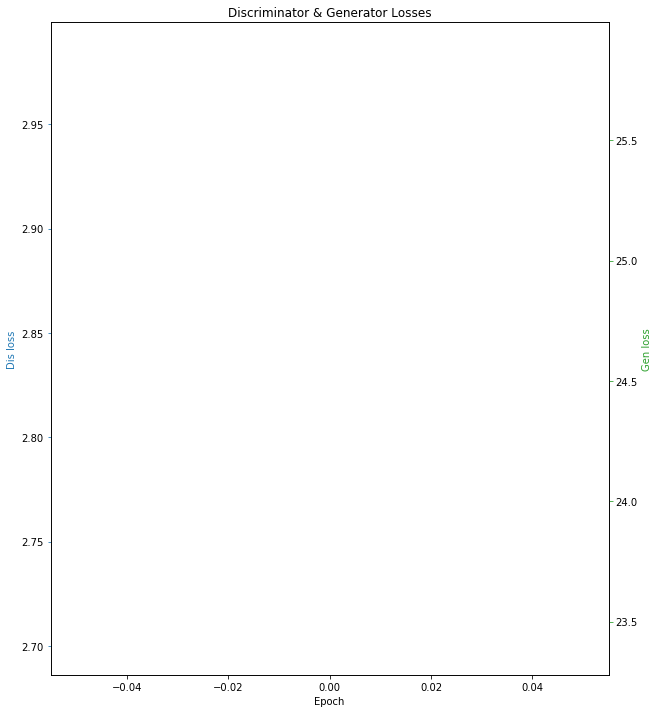


 2.0519807 21.46536
--------------- Epoch 3 ---------------




 3.5499845 21.928495
--------------- Epoch 4 ---------------


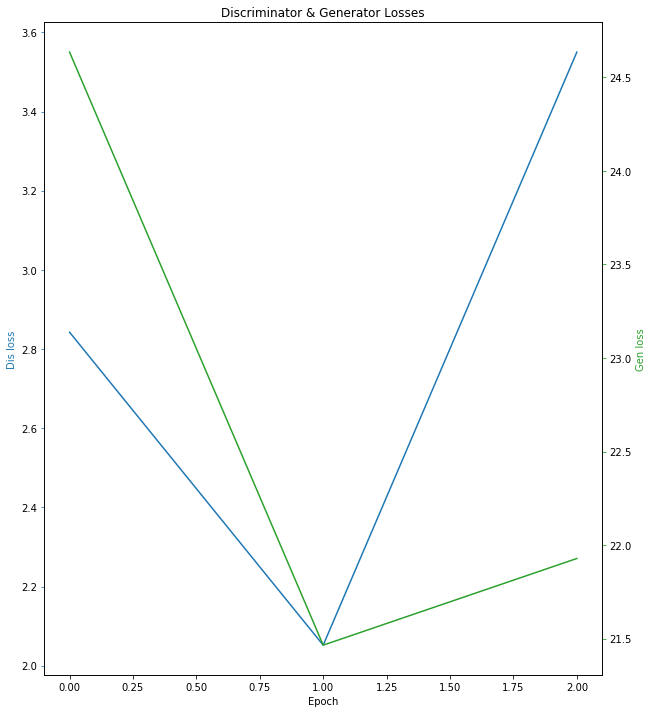


 0.058133163 20.09603
--------------- Epoch 5 ---------------




 3.650521 24.13579
--------------- Epoch 6 ---------------


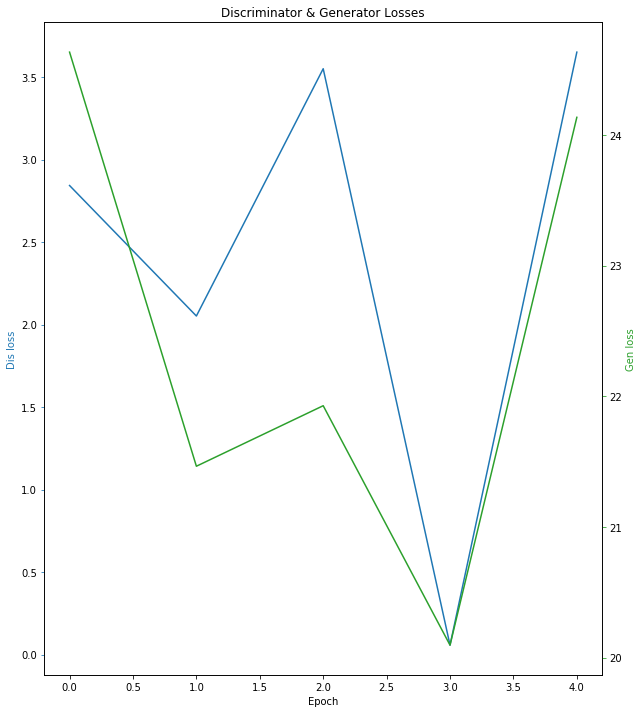


 3.8361967 20.446064
--------------- Epoch 7 ---------------




 4.1017303 15.922336
--------------- Epoch 8 ---------------


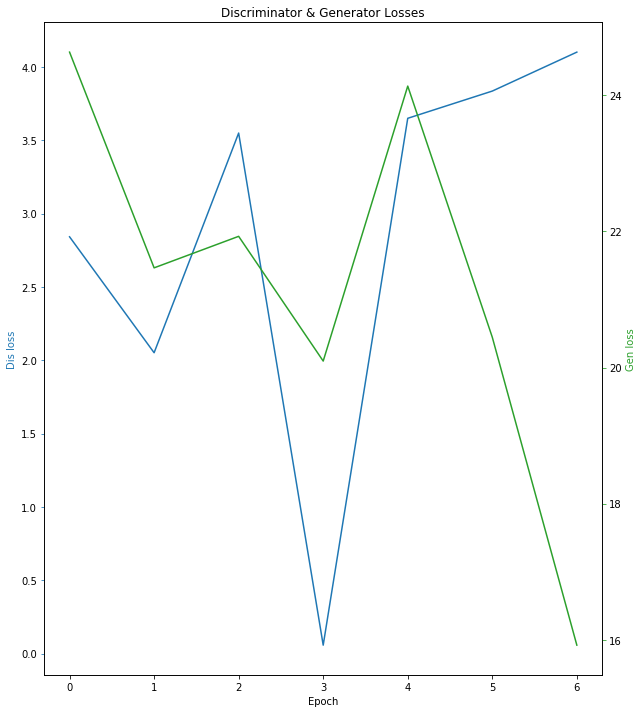


 4.3910894 16.596184
--------------- Epoch 9 ---------------




 4.1934443 18.090588
--------------- Epoch 10 ---------------


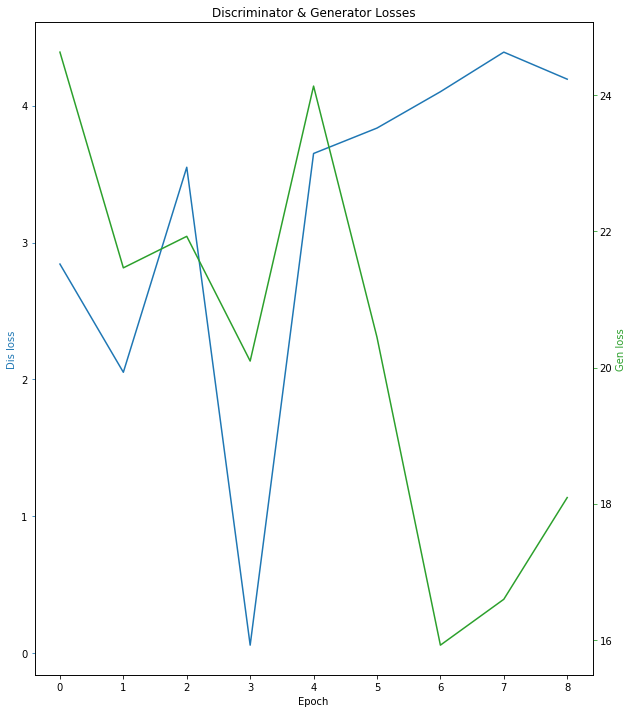


 1.0485885 14.43229


In [15]:
#model_srgan.srgan.load_weights('srgan_weights_epoch_240.h5')
model_srgan.train(10, save_interval=2 ,batch_size=16)

In [16]:
!pwd

/content/training_process


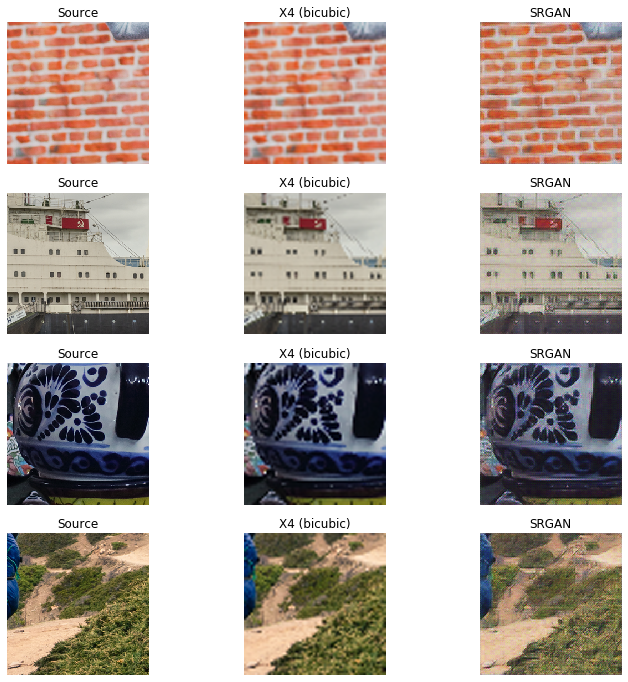

In [18]:
# Load pretrained model
model_srgan.srgan.load_weights('srgan_weights_epoch_10.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)